# Visualizando a Poesia de Belchior

Projeto final da disciplina Visualização Científica, ministrada pela professora Emanuele Santos. 

**Lucas Cabral** <br>
Universidade Federal do Ceará, Mestrado e Doutorado em Ciências da Computação<br>
2019.2

![Belchior](https://www.urbanarts.com.br/imagens/produtos/123739/0/Ampliada/amar-e-mudar-as-coisas.jpg)
*Arte: [Daniel Brandão](https://www.estudiodanielbrandao.com/)*

Antonio Carlos Belchior, mais conhecido como Belchior (Sobral, 26 de outubro de 1946 – Santa Cruz do Sul, 30 de abril de 2017), foi um compositor cearense entre os mais notórios do cancioneiro popular brasileiro.  Dono de uma obra de grande densidade e complexidade estética, literária e filosófica, suas ricas composições são objeto de estudo acadêmico e um marco da cultura cearense. Este trabalho propõe uma análise de suas composições através de técnicas de processamento de linguagem natural e de visualização de dados. Dado a riqueza poético e musica das composições de Belchior, este trabalho não tem a pretenção de realizar uma análise literária ou linguística aprofundada, mas sim, movido por curiosidade e admiração, utilizar ferramentas computacionacias para explorar os padrões sintáticos e estatísticos que permeiam o conjunto de sua obra. Nos interessa saber:

- Qual a distribuição do tamanho das letras das músicas?
- Quais os termos mais relevantes na obra toda? E por música?
- Quais letras possuem maior similaridade? 
- Qual a polaridade de sentimento e o nível de subjetividade dominante na obra? E por música? 
- Quais são as palavras que mais ocorrem juntas? 

Vamos ver o que conseguimos descobrir!  

In [1]:
#Bibliotecas utilizadas
import pandas as pd
from pyvis.network import Network
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

# Sobre os dados
As letras foram extraídas do site [Letras](https://www.letras.mus.br/) através de um [web-crawler](https://github.com/cabrau/visualizando_belchior/blob/master/scrapping_lyrics.ipynb). Dando como input o nome do artista, o web-crawler percorre a lista de todas as músicas do artista, armazenando em uma tabela o título da música, se é uma das mais tocadas e a letra, descartando músicas cuja composição não seja do artista escolhido.

Após essa coleta, os dados passaram por uma etapa de [extração de features](https://github.com/cabrau/visualizando_belchior/blob/master/pre_processing_text.ipynb) utilizando técnicas de processamento de linguagem natural, incluindo:

* Contagem de palavras por documento
* Tokenização
* Remoção de stopwords
* Normalização
* Extração de palavras-chave
* Distribuição de frequências de tokens
* Extração de nGramas
* Cálculo de matriz termo-documento (TF-IDF)
* Matriz de similaridade de documentos
* Redução de dimensionalidade com UMAP
* Análise de sentimentos
* Modelagem de tópicos

In [2]:
url_df = 'https://raw.githubusercontent.com/cabrau/visualizando_belchior/master/belchior.csv'
df = pd.read_csv(url_df)
df.head()

,titulo,maisTocada,letra,tamanho,polaridade,subjetividade,sentimento,keywords,x,y
0,A Palo Seco,1,Se você vier me perguntar por onde andei No te...,195,-0.054545,0.463636,Neutro,"quero, canto, torto",1.375039,0.437631
1,Aguapé,0,Capineiro de meu pai Não me cortes meus cabelo...,257,0.032345,0.354072,Neutro,"nada, sentada, estrada",0.303462,-2.816964
2,Alucinação,1,Eu não estou interessado Em nenhuma teoria Em ...,370,0.194898,0.600680,Positivo,"coisas, nenhuma, amar",0.100997,0.152247
3,Amor de Perdição,0,"Entrar, ficar em ti Tem sido o meu melhor peri...",213,0.156212,0.514444,Positivo,"amor, paz, deixa",1.493721,-1.233117
4,Amor e Crime,0,"Amor, não há amor Existem só provas de amor Ma...",122,0.156944,0.661905,Positivo,"amor, tudo, provas",1.749291,-1.236596


In [3]:
print('Quantidade total de músicas analisadas: ', len(df))

Quantidade total de músicas analisadas:  91


# Contagem de palavras por músicas

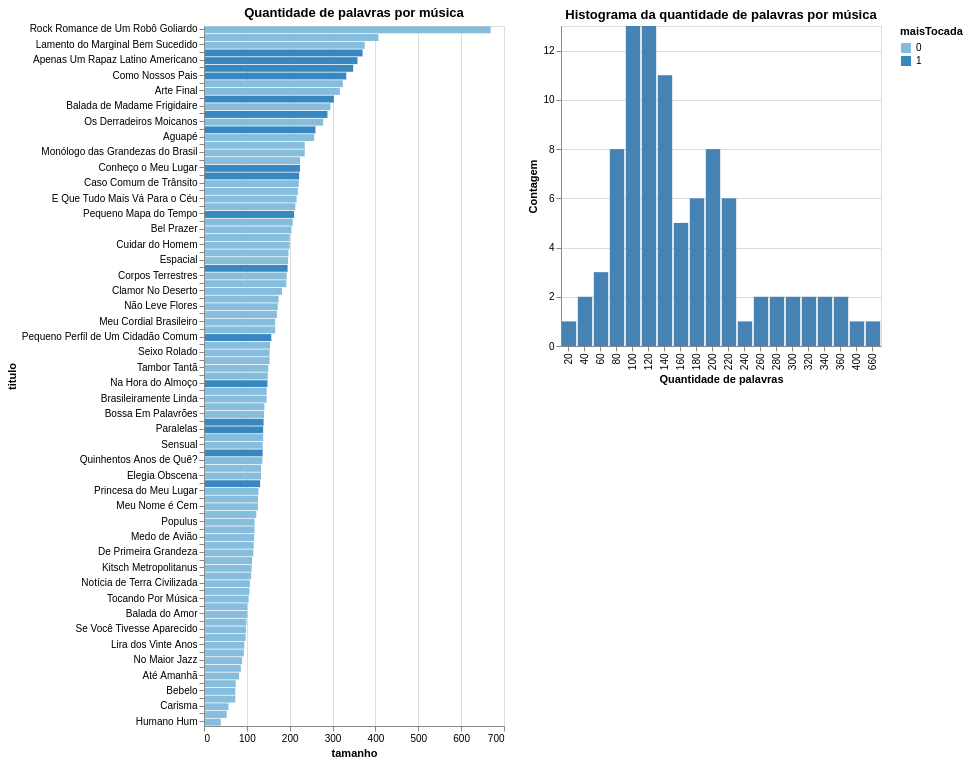

In [4]:
pts = alt.selection(type="interval", encodings=["x"])

rowbars = alt.Chart(df).mark_bar().encode(
    x='tamanho:Q',
    y= alt.Y('titulo:O', sort = alt.EncodingSortField(field="tamanho", order='descending')),   
    color = 'maisTocada:O',
    tooltip=['titulo', 'tamanho', 'keywords','letra']
).transform_filter(
    pts
).properties(    
    height=700,
    width = 300,
    title = 'Quantidade de palavras por música'
)


hist = alt.Chart(df).mark_bar().encode(
    x = alt.X('hbin:N',title='Quantidade de palavras'),
    y = alt.Y('count()',title='Contagem'),
    tooltip = [alt.Tooltip('count():Q', title='Contagem de letras'),
               alt.Tooltip('mbin:N', title='Quantidade de palavras')],
    color = alt.condition(pts, alt.value("steelblue"), alt.value("lightgray"))
).properties(
    height = 320,
    width = 320,
    title = 'Histograma da quantidade de palavras por música'
).add_selection(pts)

hconcat = alt.hconcat(
    rowbars,
    hist,
    data=df
).transform_bin(
    "hbin",
    field="tamanho",
    bin=alt.Bin(maxbins=50)
)

#hconcat = rowbars | hist

hconcat.save('1_tamanho_musicas.html')
hconcat



# Termos mais frequentes

In [5]:
url_df_freq = 'https://raw.githubusercontent.com/cabrau/visualizando_belchior/master/belchior_dist_freq.csv'
df_freq = pd.read_csv(url_df_freq)
df_freq = df_freq.sort_values(by='frequencia',ascending=False)
df_freq.head()

,termo,frequencia,musicas
113,nada,79,"Aguapé, Apenas Um Rapaz Latino Americano, Arte..."
222,amor,77,"Alucinação, Amor de Perdição, Amor e Crime, At..."
223,vida,73,"Alucinação, Apenas Um Rapaz Latino Americano, ..."
287,tudo,68,"Amor e Crime, Apenas Um Rapaz Latino Americano..."
39,quero,61,"A Palo Seco, Balada do Amor, Bel Prazer, Brinc..."


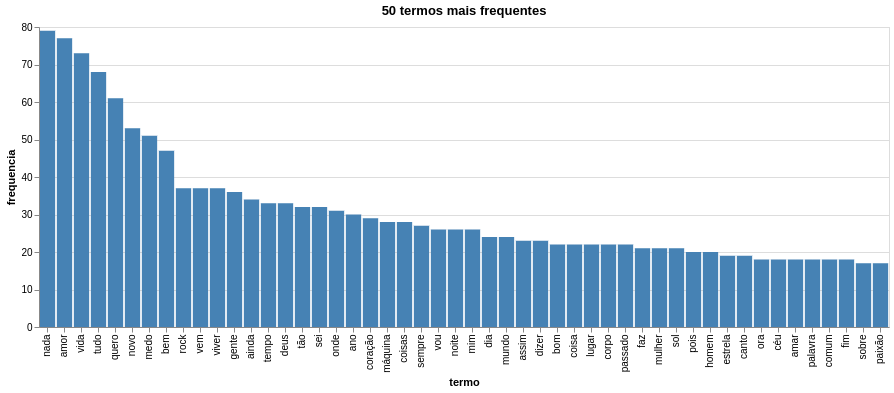

In [6]:
df_freq50 = df_freq[0:50]

wordfreq = alt.Chart(df_freq50).mark_bar().encode(
    y='frequencia:Q',
    x= alt.X('termo:O', sort = alt.EncodingSortField(field="frequencia", order='descending')),
    color = alt.value('steelblue'),
    tooltip=[
        'termo:O',
        'frequencia:Q',
        alt.Tooltip('musicas:O', title='Letras onde o termo ocorre')
    ]
).properties(    
    height=300,
    width = 850,
    title = '50 termos mais frequentes'
)

wordfreq.save('2_frequencia_termos.html')
wordfreq

## Nuvem de palavras
![WordCloud](https://github.com/cabrau/visualizando_belchior/blob/master/wordcloud.png?raw=true)

# Grafo de Co-Ocorrência
Além de conhecer os termos mais utilizados, podemos visualizar como eles aparecem em conjunto através de uma rede. Cada nó do grafo é uma palavra e uma aresta significa que estas ocorrem juntas.

In [7]:
#Create network plot 
bigram_df = pd.read_csv('https://raw.githubusercontent.com/cabrau/visualizando_belchior/master/belchior_bigrams.csv')
d = bigram_df.set_index('ngram').T.to_dict('records')
net = Network(width = '900px', height = '600px',notebook = True)
toptokens = df_freq.sort_values(by='frequencia', ascending=False).head(25)

# Create connections between nodes
for index, row in toptokens.iterrows():               
    net.add_node(row['termo'], label=row['termo'], title = row['musicas'], 
                 value = row['frequencia'])

for k, v in d[0].items():
    k = k.split()
    if(k[0] in list(toptokens['termo']) and k[1] in list(toptokens['termo'])):
        net.add_edge(k[0], k[1], weight= v*100)
        print(k[0] + "," + k[1])

nada,nada
amor,vida
amor,amor
sei,tudo
sei,nada
bem,vem
vem,ainda
mim,ainda
onde,gente
amor,ano
vida,sempre
vida,quero
rock,rock
tudo,rock
deus,deus
novo,vida
vida,amor
tudo,novo
novo,quero
ano,novo
novo,gente
amor,coisas
sei,amor
tudo,tudo
novo,sempre
sempre,vem
sei,sei
coração,vida
vida,vem
sei,vou
tempo,tempo
viver,bem
bem,vida
vida,vida
vem,viver
bem,bem
sempre,novo
novo,tudo
medo,nada
onde,nada
máquina,viver
nada,vou
nada,amor
ainda,vem
coração,gente
bem,mim
máquina,máquina
máquina,medo
tudo,bem
deus,tudo
vem,deus
novo,novo
medo,medo
nada,viver
viver,nada
quero,viver
coração,nada
coisas,sei
vem,bem
coração,medo
novo,bem
ainda,quero
sei,vida
onde,vem
viver,tão
viver,coração
tudo,tão
vou,viver
viver,coisas
quero,tudo
coração,bem


In [8]:
net.set_options("""

var options = {
  "physics": {
    "repulsion": {
      "nodeDistance": 180
    },
    "maxVelocity": 6,
    "minVelocity": 0.75,
    "solver": "repulsion"
  }
}

""")

In [9]:
#net.show_buttons(filter_=['physics'])
net.save_graph('3_network.html')
net.show("3_network.html")

# Similaridade entre músicas

Uma técnica bastante utilizada em processamento de linguagem natural é o cáculo do [TF-IDF](https://pt.wikipedia.org/wiki/Tf%E2%80%93idf). O valor tf–idf (abreviação do inglês *term frequency–inverse document frequency*), é uma medida estatística que tem o intuito de indicar a importância de uma palavra de um documento em relação a uma coleção de documentos ou em um corpus linguístico. Através desse cálculo pode-se vetorizar um documento em um espaço n-dimensional, onde n é o tamanho do vocabulário. Assim cada indice dos vetores represanta um signo linguístico do vocabulário, e o seu valor é o tf-idf daquele termo naquele documento. Vetorizando os documentos, pode-se comparar quais são mais similares. Uma métrica básica bastante utilizada é a [distância cosseno](https://en.wikipedia.org/wiki/Cosine_similarity)

In [10]:
url_sim = 'https://raw.githubusercontent.com/cabrau/visualizando_belchior/master/belchior_similaridade.csv'
df_sim = pd.read_csv(url_sim)

In [11]:
source = df_sim.melt(id_vars=['titulo'])

In [12]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

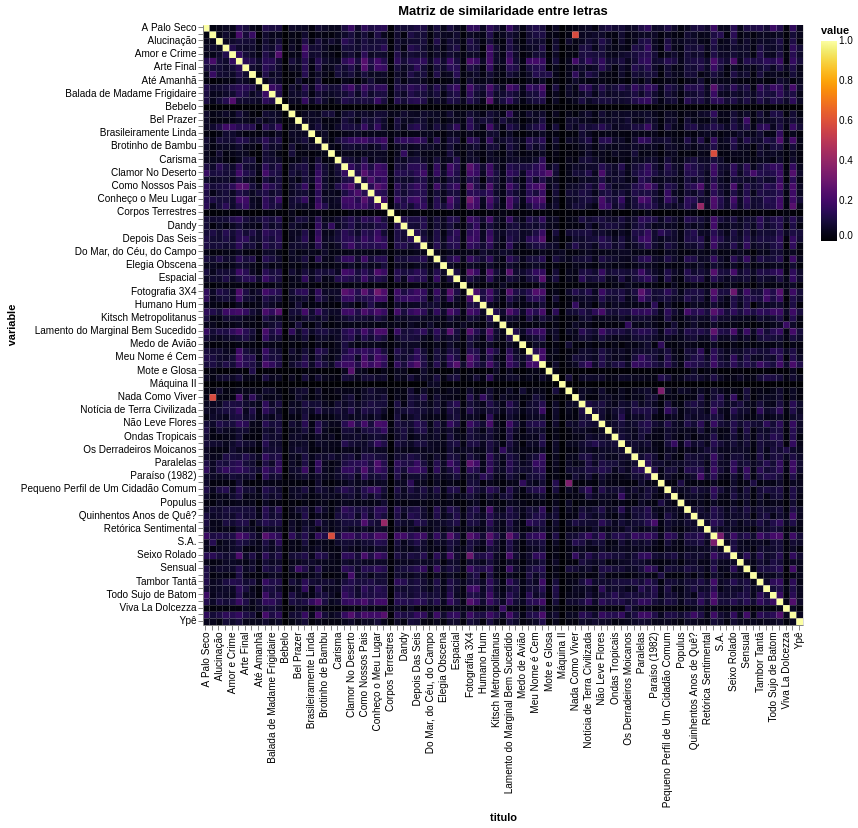

In [13]:
matrix_sim = alt.Chart(source).mark_rect().encode(
    x='titulo:O',
    y='variable:O',
    color=alt.Color('value:Q', scale=alt.Scale(scheme="inferno")),
    tooltip=[
        alt.Tooltip('variable:O', title='Letra A'),
        alt.Tooltip('titulo:O', title='Letra B'),
        alt.Tooltip('value:Q', title='Similaridade'),
    ]
).properties(    
    width = 600,
    height= 600,    
    title = 'Matriz de similaridade entre letras'
)
matrix_sim.save('4_similaridade_musicas.html')
matrix_sim

# Análise de Sentimentos

Esta análise foi realizada utilizando a biblioteca [TextBlob](https://textblob.readthedocs.io/en/dev/). Através de um algoritimo de regressão supervisionado, treinado previamente, dado um texto como entrada a biblioteca estima um valor real para polaridade, em uma escala de -1 (mais negativo) a 1 (mais positivo) e subjetividade em uma escala que varia de 0 (totalmente objetivo), até 1 (totalmente subjetivo). Entretanto, o modelo foi treinado em inglês. Portanto, foi feita uma tradução de cada letra para este idioma, utilizando a mesma biblioteca, para então ser realizada a análise de sentimento. É necessário considerar as limitações dessa abordagem. Primeiro, em algumas composições Belchior explora o uso de linguagem abstratas, com fonemas que não são reconhecidos pelo vocabulário. Além disso, não é muito claro na documentação do TextBlob o significado das escalas de subjetividade e polaridade. Por último, não sabe-se com exatidão o efeito da tradução na análise de sentimento. Nas palavras de Robert Frost, "poesia é o que se perde na tradução". Apesar de tudo, essa técnica permitiu uma exploração interessante do conjunto da obra do compositor e pode ser um passo inicial para análises mais aprofundadas. 

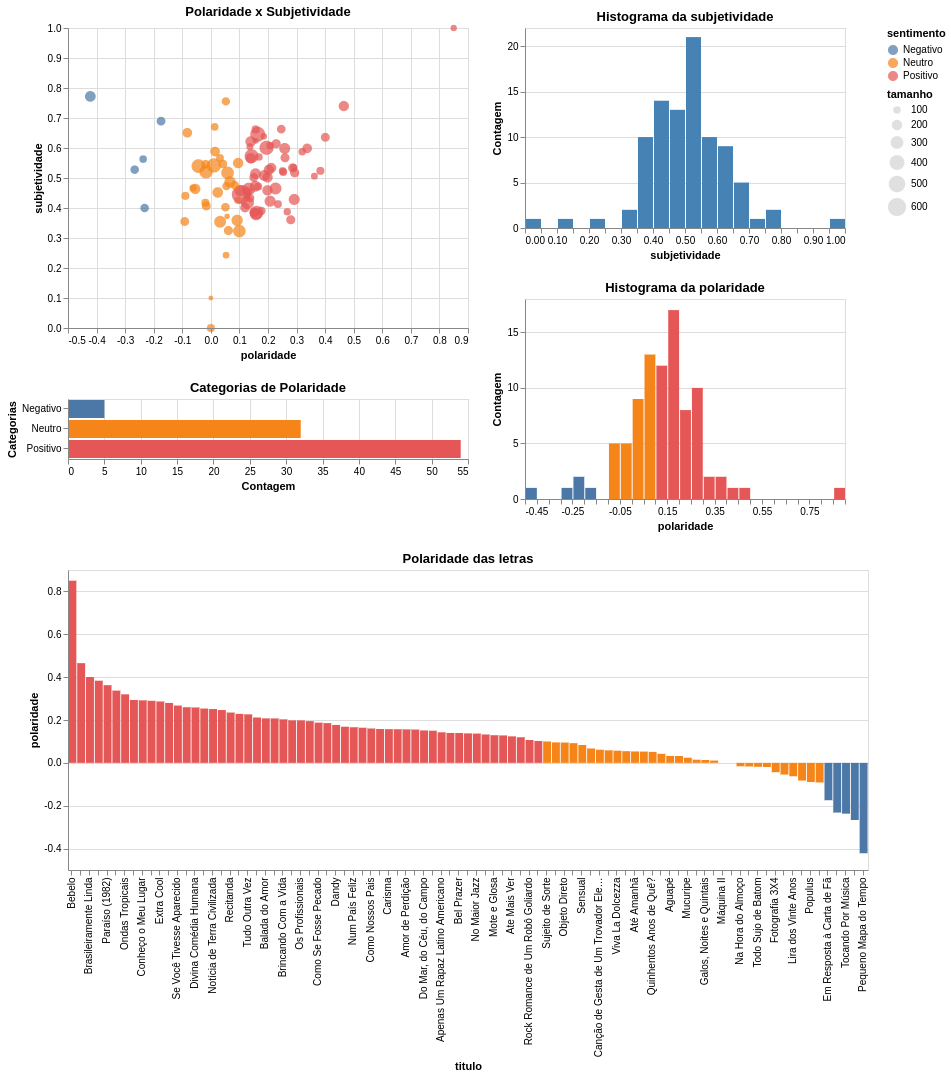

In [14]:
brush = alt.selection(type='interval')

pts = alt.selection(type="interval", encodings=["x"])

points = alt.Chart(df).mark_circle().encode(
    x='polaridade:Q',
    y='subjetividade:Q',
    color=alt.condition(brush, 'sentimento:N', alt.value('lightgray')),
    tooltip=['titulo','polaridade','subjetividade','letra'],
    size='tamanho:Q'
).properties(    
    title = 'Polaridade x Subjetividade'
).add_selection(
    brush
).transform_filter(
    pts
)

bars = alt.Chart(df).mark_bar().encode(
    y=alt.Y('sentimento:N', title = 'Categorias'),
    color='sentimento:N',
    x=alt.X('count(sentimento):Q', title = 'Contagem'),
    tooltip = [alt.Tooltip('count():Q', title='Contagem')],
).properties(    
    title = 'Categorias de Polaridade'
).transform_filter(
    brush
).transform_filter(
    pts
)

hist_pol = alt.Chart(df).mark_bar().encode(
    x = alt.X("polaridade:Q", bin=alt.Bin(maxbins=30),title = 'polaridade'),
    y =alt.Y('count()',title='Contagem'),
    tooltip = [alt.Tooltip('count():Q', title='Contagem')],
    color = alt.condition(pts, 'sentimento:N', alt.value("lightgray"))
).properties(    
    width = 320,
    height = 200,
    title = 'Histograma da polaridade'
).add_selection(pts)


hist_sub = alt.Chart(df).mark_bar().encode(
    x = alt.X("subjetividade:Q", bin=alt.Bin(maxbins=30),title = 'subjetividade'),
    y =alt.Y('count()',title = 'Contagem'),
    tooltip = [alt.Tooltip('count():Q', title='Contagem')],
    color = alt.condition(pts, alt.value("steelblue"), alt.value("lightgray"))
).properties(    
    width = 320,
    height = 200,
    title = 'Histograma da subjetividade'
).add_selection(pts)

sent = alt.hconcat(
    points & bars,
    hist_pol & hist_sub,
    data=df
)

pol = alt.Chart(df).mark_bar().encode(
    y="polaridade:Q",
    x= alt.X("titulo:O", sort = alt.EncodingSortField(field="polaridade", order='descending')),
    tooltip = ['titulo','polaridade','letra'],
    color= 'sentimento'
).properties(
    width=800,
    height = 300,
    title = 'Polaridade das letras'
).transform_filter(
    pts
)

sent = ((points & bars) | (hist_sub & hist_pol)) & pol
sent.properties(title = 'Análise de Sentimentos')
sent.save('5_sentimentos.html')
sent